In [2]:
import pickle
import hddCRP.behaviorDataHandlers
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:

num_runs = 4;
num_warmup_samples = 5000
num_samples        = 10000
overwrite_existing_results = False

sequential_distances_only = True # if false, model setup more as a "smoother". If true, can simulate from the model

if(sequential_distances_only):
    results_directory = "Results/sequentialModel/"
else:
    results_directory = "Results"
if(not os.path.exists(results_directory)):
    os.makedirs(results_directory)

data_filename = 'data/Data_turns_all_by_session.pkl';
with open(data_filename, 'rb') as data_file:
    data = pickle.load(data_file)

subjects = list(data["data"].keys())
subjects = ["A1"]
subjects.sort()
print("subjects = " + str(subjects))

subjects = ['A1']


In [ ]:
#for run_idx in range(num_runs):
for run_idx in range(runs):
    for subject_idx, subject in enumerate(subjects):
        filename = "{results_directory}/Subject_{subject_id}_run_{run_idx}.pkl".format(results_directory=results_directory, subject_id=subject, run_idx=run_idx)
        if(not os.path.isfile(filename) or overwrite_existing_results):
            # for each run, should do some randomization of initial parameters (with known seeds so we can repeat everything)

            seed = subject_idx * 1000 + run_idx;
            rng = np.random.Generator(np.random.MT19937(seed))

            sequences = data["data"][subject]["data"]; # turns in each session
            session_types = data["data"][subject]["task"] # which maze

            ii = session_types.index("C")
            sequences = [sequences[ii]]
            session_types = [session_types[ii]]


            model = hddCRP.behaviorDataHandlers.create_hddCRP(sequences, session_types, rng = rng, sequential_distances_only=sequential_distances_only)

            tau_names = [str(xx) for xx in model.weight_param_labels]
            alphas_names = ["alpha_concentration_no_context", "alpha_concentration_one_back_context", "alpha_concentration_two_back_context"]
            model, samples, step_size_settings = hddCRP.behaviorDataHandlers.sample_model_for_maze_data(model, num_samples=num_samples, num_warmup_samples=num_warmup_samples)
            
            MCMC_info = {"step_size_settings" : step_size_settings.to_dict(),
                        "num_warmup_samples" : num_warmup_samples,
                        "num_samples" : num_samples,
                        "seed" : seed, 
                        "sequential_distances_only" : sequential_distances_only}
            samples["tau_parameter_names"] = tau_names
            samples["alphas_names"] = alphas_names
            
            # save results to filename
            with open(filename, "wb") as results_file:
                results_data = {"MCMC_info" : MCMC_info,
                                "samples" : samples}
                pickle.dump(results_data, results_file)

In [8]:
# example for loading results and computing estimates with error bars for a single subject
subject = 'A1'


taus = np.zeros((10000,2,4))
alphas = np.zeros((10000,3,4))

for run_idx in range(4):
    filename = "{results_directory}/Subject_{subject_id}_run_{run_idx}.pkl".format(results_directory=results_directory, subject_id=subject, run_idx=run_idx)
    with open(filename, "rb") as file:
        results = pickle.load(file)

        ss = range(results["MCMC_info"]["num_warmup_samples"], results["MCMC_info"]["num_warmup_samples"]+results["MCMC_info"]["num_samples"])
        taus[:,:,run_idx] = np.exp(results["samples"]["log_taus"][ss,:]).squeeze()
        alphas[:,:,run_idx] = results["samples"]["alphas"][ss,:]

        # ci_range = [2.5, 97.5]

        # mean_taus = np.mean(taus, axis=0)
        # mean_alphas = np.mean(alphas, axis=0)
        # std_taus = np.std(taus, axis=0)
        # std_alphas = np.std(alphas, axis=0)
        # ci95_taus = np.percentile(taus, ci_range, axis=0)
        # ci95_alphas = np.percentile(alphas, ci_range, axis=0)

        # accepted = results["samples"]["accepted"][ss]
        # print("Fraction of accepted MH samples: " + str(np.mean(accepted)))

    # plt.subplot(1,2,1)
    # plt.plot(taus)

    # plt.subplot(1,2,2)
    # plt.plot(alphas)
    # plt.show()


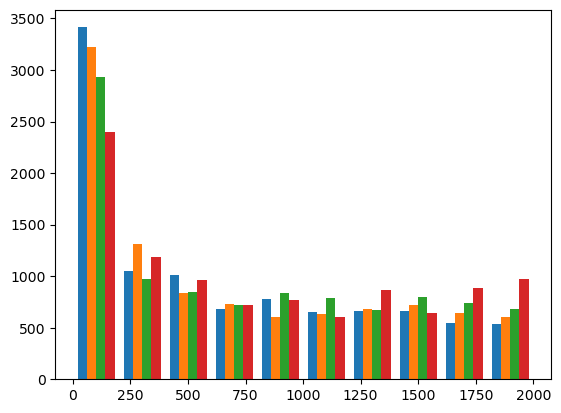

In [16]:
plt.hist(alphas[:,0,:].squeeze());